# 단층 퍼셉트론 by 파이토치

In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

In [2]:
x = torch.FloatTensor(range(5)).unsqueeze(1)
y = 2*x + torch.rand(5,1)

In [4]:
class LinearRegressor(nn.Module):
    def __init__(self):
        super().__init__()  # 모델 연산 정의
        self.fc = nn.Linear(1,1,bias=True)

    def forward(self, x):
        y = self.fc(x)

        return y

In [7]:
model = LinearRegressor()

In [9]:
learning_rate = 1e-3
criterion = nn.MSELoss()    # MSE를 손실 함수로!!
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
loss_stack = []
for epoch in range(1001):

    optimizer.zero_grad()

    y_hat = model(x)
    loss = criterion(y_hat,y)

    loss.backward()
    optimizer.step()
    loss_stack.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}:{loss.item()}')

Epoch 0:22.256725311279297
Epoch 100:1.7618697881698608
Epoch 200:0.36408719420433044
Epoch 300:0.2534424066543579
Epoch 400:0.2312750518321991
Epoch 500:0.21671831607818604
Epoch 600:0.2041444331407547
Epoch 700:0.1930088996887207
Epoch 800:0.18312831223011017
Epoch 900:0.17436006665229797
Epoch 1000:0.1665787398815155


예측된 학습이 아니기에 with torch.no_grad()를 통해 requires_grad 비활성화!!

In [11]:
with torch.no_grad():
    y_hat = model(x)

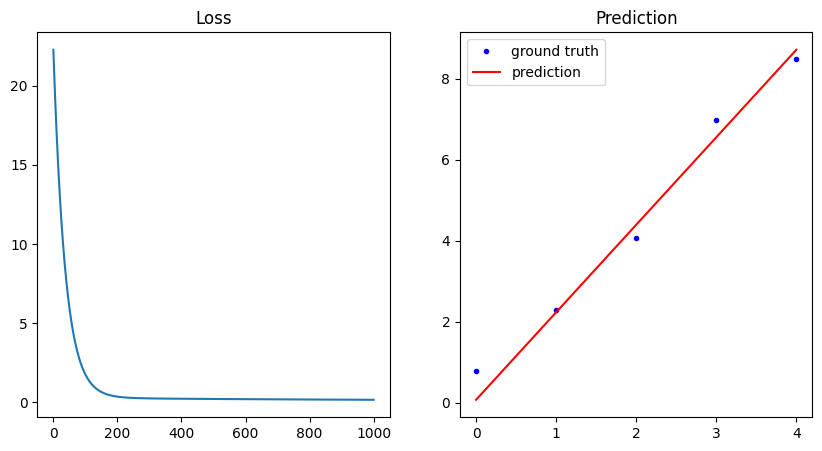

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")
plt.subplot(122)
plt.plot(x, y,'.b')
plt.plot(x, y_hat, 'r-')
plt.legend(['ground truth','prediction'])
plt.title("Prediction")
plt.show()

# 집값 예측하기 by MLP

nn.LInear()를 줄지어 여러 층으로 구성된 깊은 신경망 제작!!

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
cd /content/gdrive/MyDrive/Pytorch_sample/data

/content/gdrive/MyDrive/Pytorch_sample/data


In [31]:
import pandas as pd # 데이터프레임 형태를 다룰 수 있는 라이브러리
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.

# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

# Loss
from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.

# Plot
import matplotlib.pyplot as plt # 시각화 도구

In [32]:
df = pd.read_csv('reg.csv', index_col=[0])

In [33]:
# 데이터프레임 보여주기
# df.head()는 상위 5줄만 보여준다.
# df.head(10) 괄호 안에 숫자 10을 넣으면 10줄을 보여준다.
df.head(10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333
5,0.038651,0.019568,0.139449,0.719852,0.560581,0.610531,0.578661,0.387926,0.133629,0.072967,0.514078,0.986385,0.127396,0.526667
6,0.033301,0.136658,0.336651,0.274996,0.472140,0.331155,0.643546,0.661869,0.270651,0.239929,0.475964,0.993516,0.300521,0.397778
7,0.026858,0.151993,0.300627,0.115449,0.463345,0.532618,0.938389,0.465781,0.139893,0.238901,0.243669,0.991425,0.431171,0.491111
8,0.021739,0.132378,0.259349,0.488716,0.389581,0.411536,0.984672,0.526151,0.201324,0.236329,0.306712,0.965204,0.767177,0.255556
9,0.014588,0.144471,0.331099,0.759479,0.696532,0.334544,0.834204,0.611416,0.174935,0.237351,0.437982,0.967070,0.445798,0.308889


In [36]:
# 데이터 프레임을 넘파이 배열로 만들기
# df에서 Price 제외한 나머지는 변수로 사용!
X = df.drop('Price', axis=1).to_numpy()
Y = df['Price'].to_numpy().reshape((-1,1))

In [35]:
# 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
# 기준으로 잡은 논문이 전체 데이터를 50%, 50%로 나눴기 때문에 test size를 0.5로 설정한다.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [38]:
# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [39]:
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

모델 구축하기

In [ ]:
# Regressor는 입력층 1개, 은닉층 2개, 출력층 1개를 가진 모델이다
# 입력층 노드 13개, 출력층 노드 1개

In [41]:
# 각 은닉층마다 50, 30개의 노드를 갖도록!!
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.5) # 연산이 될 때마다 50%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.

        return x


# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

In [43]:
# 모델 학습하기
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7) # Adam으로 최적화 방법 정의
# weight decay는 L2 정규화에서 패널티 값을 의미!!

In [44]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트
n = len(trainloader)

for epoch in range(400): # 400번 학습을 진행한다.

    running_loss = 0.0

    for data in trainloader: # 무작위로 섞인 32개 데이터가 있는 배치가 하나 씩 들어온다.

        inputs, values = data # data에는 X, Y가 들어있다.

        optimizer.zero_grad() # 최적화 초기화

        outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
        loss = criterion(outputs, values) # 손실 함수 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정
        optimizer.step() # 역전파를 진행하고 가중치 업데이트

        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.

    loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

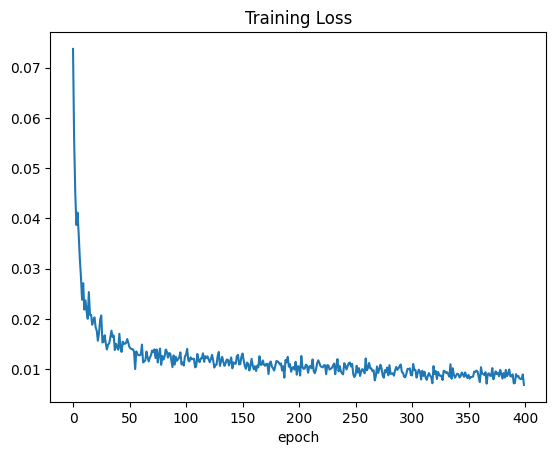

In [45]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

모델 평가하기

In [49]:
# 최종 모델 평가는 RMSE를 사용한다!!

def evaluation(dataloader):
    # 예측값과 그에 대응하는 실제값 저장 위해 빈 텐서 만든다
    predictions = torch.tensor([], dtype=torch.float)
    actual = torch.tensor([], dtype=torch.float)
    with torch.no_grad():   # requires_grad 비활성화
        model.eval()
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)
            predictions = torch.cat((predictions, outputs), 0)  # cat 통해 예측값을 누적함
            actual = torch.cat((actual, values), 0) # cat 통해 실제값을 누적함

    predictions = predictions.numpy()  # 넘파이 배열로 변경
    actual = actual.numpy()     # 넘파이 배열로 변경
    rmse = np.sqrt(mean_squared_error(predictions, actual))  # sklearn을 이용하여 RMSE 계산

    return rmse

# 평가 시 .eval()을 사용해야 하는 이유
# 평가 시에는 온전한 모델로 평가를 해야하는데 .eval()이 아닌 .train()인 경우 드랍아웃이 활성화 되어 있다.
# 따라서 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들을 평가 시에는 비활성화 해야만 한다.

In [50]:
train_rmse = evaluation(trainloader) # 학습 데이터의 RMSE
test_rmse = evaluation(testloader) # 시험 데이터의 RMSE

print("Train RMSE: ",train_rmse)
print("Test RMSE: ",test_rmse)

# 예시를 위한 단순 비교입니다. 실제 연구에서는 디테일한 비교가 필요합니다.
# 데이터를 무작위로 나누고 모델의 초기값도 random initial parameter를 사용했기 때문에 학습을 할 때 마다 결과가 다르게 나올 수 있습니다.
# 이 강의에서는 학습의 흐름(for문)과 모델(Regressor) 부분을 주의 깊게 보시면 됩니다.

Train RMSE:  0.07272544
Test RMSE:  0.10528318
